In [1]:
import pandas as pd
import numpy as np
import json

## READ DATA AND PERFORM EDAs

In [2]:
with open("News_Category_Dataset_v3.json", 'r') as file:
    # Load JSON data into a list of dictionaries
    json_list = [json.loads(line) for line in file]
    
df = pd.DataFrame(json_list)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.to_csv("News_Category_Dataset_v3.csv")
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


### Control Totals

In [3]:
df.shape

(209527, 6)

In [4]:
df.columns

Index(['link', 'headline', 'category', 'short_description', 'authors', 'date'], dtype='object')

In [5]:
print(f"Number of unique categories in the dataset: {len(df['category'].unique())}")

Number of unique categories in the dataset: 42


In [6]:
print(f"Number of unique authors in the dataset: {len(df['authors'].unique())}")

Number of unique authors in the dataset: 29169


In [7]:
print(f"Number of unique years in the dataset: {len(df['date'].dt.year.unique())}")

Number of unique years in the dataset: 11


### Null Checks

In [8]:
print(f"Number of unique categories in the dataset: {len(df['category'].unique())}")

Number of unique categories in the dataset: 42


In [9]:
df.isna().sum()

link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
dtype: int64

There are no null values in the dataset

In [10]:
for col in df.columns:
    print(col, df[df[col]==''].shape[0])

link 0
headline 6
category 0
short_description 19712
authors 37418
date 0


There are 19K rows in short description column that have a blank string - therefore 9.4% of the dataset is unusable based on short description alone. However, most reviews have a headline, so they can still be retained at this step of the analysis

In [11]:
# Removing rows that have no headline:

df = df[df['headline']!='']

print(f"Remaining rows in the dataset: {df.shape[0]}\n")
for col in df.columns:
    print(col, df[df[col]==''].shape[0])

Remaining rows in the dataset: 209521

link 0
headline 0
category 0
short_description 19707
authors 37418
date 0


### Distribution of the articles by category, year

#### By Category

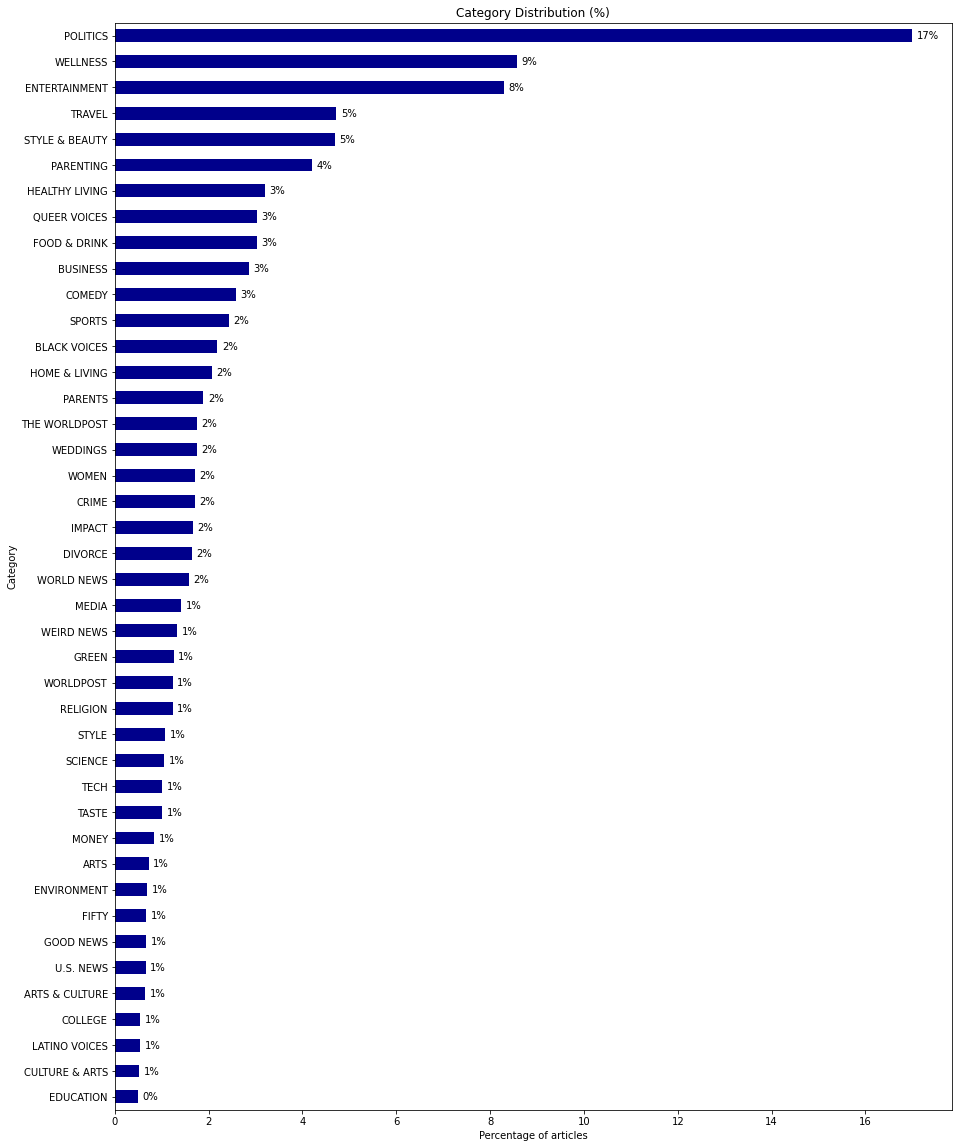

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 20))
counts = df['category'].value_counts(ascending=True)
percentages = (counts / counts.sum()) * 100
ax = percentages.plot(kind='barh', color='darkblue')

for i, (count, percentage) in enumerate(zip(counts, percentages)):
    ax.text(percentage + 0.1, i, f'{percentage:.0f}%', ha='left', va='center', color='black')
    
plt.title('Category Distribution (%)')
plt.xlabel('Percentage of articles')
plt.ylabel('Category')
plt.show()

##### OBSERVATIONS:
'STYLE' (2254 articles) seems like it can be a subset 'STYLE & BEAUTY' (9814 articles)

'CULTURE & ARTS', 'ARTS & CULTURE', and 'ARTS' categories seem to be very close to each other in meaning and in count.

'WORLDPOST' (2579) could be the same as 'THE WORLDPOST' (3664)

'COLLEGE'  (1144) could be a subcategory of 'EDUCATION'  (1014)

'TASTE' (2096) could be a subcategory of 'FOOD & DRINK'  (6340)
##### It is worthwhile to examine with further analysis if the above categories can be combined into the same one as it would help with reducing the imabalance in the dataset and have cleaner categories

#### By Years

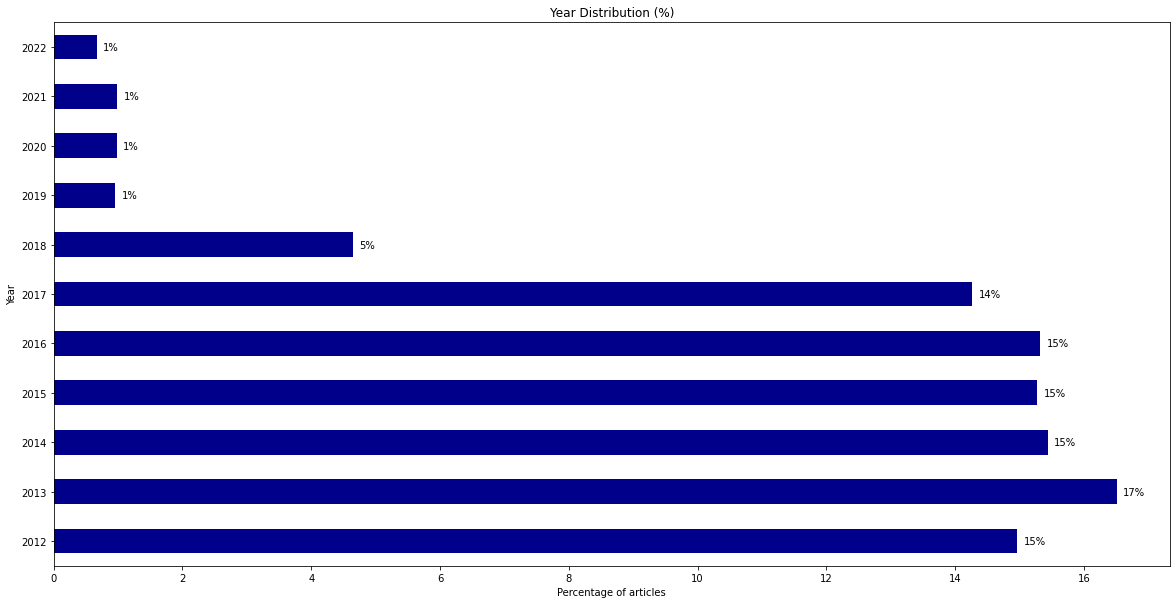

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
counts = df['date'].dt.year.value_counts(ascending=True).sort_index()
percentages = (counts / counts.sum()) * 100
ax = percentages.plot(kind='barh', color='darkblue')

for i, (count, percentage) in enumerate(zip(counts, percentages)):
    ax.text(percentage + 0.1, i, f'{percentage:.0f}%', ha='left', va='center', color='black')
    
plt.title('Year Distribution (%)')
plt.xlabel('Percentage of articles')
plt.ylabel('Year')
plt.show()

# ESTABLISHING BASELINES

## Dense Vector with NN & Non-NN models

### Preprocess

In [14]:
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

def nltk_pos_to_wordnet_pos(nltk_pos):
    if nltk_pos.startswith('J'):
        return wordnet.ADJ
    elif nltk_pos.startswith('V'):
        return wordnet.VERB
    elif nltk_pos.startswith('N'):
        return wordnet.NOUN
    elif nltk_pos.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [15]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import string

# nltk.download('punkt')
# nltk.download('stopwords')

def preprocess_text(text, tasks, verbose=False):
    
    print(f"Original Text: {text}") if verbose else None
    
    # Removing leading and training quotation marks
    text = text.strip('"')
    print(f"Cleaned Text: {text}") if verbose else None

    # Convert to lowercase
    if 1 in tasks:
        tokens = text.lower()
        print(f"Lowercased Text: {tokens}") if verbose else None
    
    # Tokenize the text
    if 2 in tasks:
        tokens = word_tokenize(tokens)
        print(f"Tokenized Text: {tokens}") if verbose else None

    # POS Tagging
    if 3 in tasks:
        pos_tagged = pos_tag(tokens)
        print(f"POS Tags for Text: {tokens}") if verbose else None
    
    # Remove punctuation
    if 4 in tasks:
        tokens = [token for token in tokens if token not in string.punctuation]
        print(f"Punctuations Removed Text: {tokens}") if verbose else None
        
    # Stemming
    if 5 in tasks:
        porter = PorterStemmer()
        tokens = [porter.stem(word) for word in tokens]
        print(f"Stemmed Text: {tokens}") if verbose else None
        
    # Simple Lemmatization
    if 6 in tasks:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        print(f"Lemmatized (wo POS Tags) Text: {tokens}") if verbose else None
        
    # Lemmatization with POS Tagging
    if 7 in tasks:
        if not pos_tagged:
            raise("Enable task POS Tagging (3) for Lemmatization with POS Tagging (7)")
        
        else:
            # Lemmatize each word with its part-of-speech tag
            lemmatizer = WordNetLemmatizer()
            lemmatized_words = []
            for word, pos in words_and_pos:
                wordnet_pos = nltk_pos_to_wordnet_pos(pos) or wordnet.NOUN
                lemmatized_words.append(lemmatizer.lemmatize(word, pos=wordnet_pos))
            tokens = lemmatized_words
            print(f"Lemmatized (w POS Tags) Text: {tokens}") if verbose else None

    return tokens

In [16]:
df['article'] = df['headline'] + ': ' + df['short_description']
df['preprocessed_tokens_12'] = df['article'].apply(lambda x: preprocess_text(x, [1, 2]))
df.head()

,link,headline,category,short_description,authors,date,article,preprocessed_tokens_12
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,Over 4 Million Americans Roll Up Sleeves For O...,"[over, 4, million, americans, roll, up, sleeve..."
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,"American Airlines Flyer Charged, Banned For Li...","[american, airlines, flyer, charged, ,, banned..."
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,23 Of The Funniest Tweets About Cats And Dogs ...,"[23, of, the, funniest, tweets, about, cats, a..."
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,The Funniest Tweets From Parents This Week (Se...,"[the, funniest, tweets, from, parents, this, w..."
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22,Woman Who Called Cops On Black Bird-Watcher Lo...,"[woman, who, called, cops, on, black, bird-wat..."


### Generate word embeddings

In [17]:
from gensim.models import Word2Vec, FastText

def train_and_get_embeddings(tokenized_text: pd.Series, model_type: str, params: dict):
    """
    Trains a specified dense vector model on a given pandas Series of text data.

    :param text_column: pandas Series with text data
    :param model_type: Type of model to train ('skipgram', 'cbow', or 'fasttext')
    :param params: Dictionary containing the training parameters
    :return: The trained model
    """
    
    # Validate model type before proceeding
    allowable_models = ['word2vec', 'fasttext']
    if model_type not in allowable_models:
        raise ValueError(f"Invalid model type specified. Choose from the following: {allowable_models}")
        
    # Train the model based on the specified type
    if model_type == 'word2vec':
        model = Word2Vec(sentences=tokenized_text, **params)
    elif model_type == 'fasttext':
        model = FastText(sentences=tokenized_text, **params)
                         
    return model

In [18]:
def document_vector(tokenized_text, model):
    
    # remove out-of-vocabulary words
    tokenized_text = [word for word in tokenized_text if word in model.wv.index_to_key]
    if len(tokenized_text) >= 1:
        return np.mean(model.wv[tokenized_text], axis=0)
    else:
        return np.zeros(model.vector_size)

In [19]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and test sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42, stratify=df['category'])

In [20]:
## ************* uncomment for first run *******************

# Train model and get word embeddings 
# skipgram_word2vec_model = train_and_get_embeddings(train_data['preprocessed_tokens_12'], 'word2vec', {'vector_size': 100, 'window': 5, 'min_count': 1, 'sg':1})
# skipgram_word2vec_model.save('skipgram_word2vec_model_v1.w2v')

In [21]:
## ************* uncomment for first run *******************

# Train model and get word embeddings 
# skipgram_fasttext_model = train_and_get_embeddings(train_data['preprocessed_tokens_12'], 'fasttext', {'vector_size': 100, 'window': 5, 'min_count': 1, 'sg':1})
# skipgram_fasttext_model.save('skipgram_fasttext_model_v1.w2v')

### Train non-NN Models

Word2Vec generates dense vector representations of words, where each word is represented by a continuous-valued vector in a high-dimensional space. These word vectors can capture syntactic and semantic word relationships based on the context in which words appear. When using these vectors as features, you can potentially improve the performance of various machine learning models, including those you mentioned. However, there are some nuances to consider for each:

<b>Multinomial Naive Bayes:</b> This model is traditionally used with discrete features (like word counts or TF-IDF scores). It assumes that features have a multinomial distribution which is not the case with dense word vectors that are real-valued. You could still use Word2Vec features with Naive Bayes, but a Gaussian Naive Bayes might be more appropriate because it can handle continuous input.

<b>Support Vector Machine:</b> SVM works well with high-dimensional data and can handle dense vectors effectively. Using Word2Vec embeddings with SVM is a common practice, especially with non-linear kernels that can capture complex relationships.

<b>Logistic Regression:</b> Similar to SVM, logistic regression can work with dense input features. It makes fewer assumptions about the distribution of the input features compared to Naive Bayes, so it's more suitable for real-valued vectors produced by Word2Vec.

<b>K-Nearest Neighbors (KNN):</b> KNN can technically work with any kind of features, as long as you can define a distance metric. Word2Vec embeddings can be used with KNN, but it's worth noting that KNN can become computationally expensive with high-dimensional data, especially if you have a large dataset because it relies on distance computations between 

#### Therefore, we will experiment with SVM and Logistic Regression

In [22]:
embedding_model = Word2Vec.load('skipgram_word2vec_model_v1.w2v')
len(embedding_model.wv)

108173

In [23]:
# Use trained model to generate document vectors
embedding_model = Word2Vec.load('skipgram_word2vec_model_v1.w2v')
X_train = np.vstack(train_data['preprocessed_tokens_12'].apply(lambda x: document_vector(x, embedding_model)))
X_test = np.vstack(test_data['preprocessed_tokens_12'].apply(lambda x: document_vector(x, embedding_model)))

# Get the labels
y_train = train_data['category'].values
y_test = test_data['category'].values

In [24]:
from sklearn.preprocessing import StandardScaler

# Standardize the feature vectors since SVM and Logistic Regression are sensitive to the scale of input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Linear SVM

In [67]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score
import pickle

# ***************** Uncomment to train model *********************
# # Train linear SVM
# svm_linear = SVC(kernel='linear', class_weight='balanced', random_state=42) #The class_weight='balanced' parameter will automatically weight the classes inversely proportional to their frequency, which is useful when working with imbalanced data sets.
# svm_linear.fit(X_train, y_train)

# # Save Model
# with open('svm_linear.pkl', 'wb') as file:
#     pickle.dump(svm_linear, file)

# *****************************************************************

with open('svm_linear.pkl', 'rb') as file:
    loaded_model = pickle.load(file)


In [38]:
# Evaluate on train
y_pred_linear = loaded_model.predict(X_train)
accuracy_linear = accuracy_score(y_train, y_pred_linear)
f1_score_linear = f1_score(y_train, y_pred_linear, average='weighted')
report_linear = classification_report(y_train, y_pred_linear)

print('Linear Kernel SVM Results on Training set:')
print(f'Accuracy: {accuracy_linear}')
print(f'F1-score: {f1_score_linear}')
print(report_linear)

Linear Kernel SVM Results on Training set:
Accuracy: 0.47562285223367695
F1-score: 0.5029475093760939
                precision    recall  f1-score   support

          ARTS       0.19      0.46      0.26      1207
ARTS & CULTURE       0.16      0.38      0.22      1071
  BLACK VOICES       0.32      0.28      0.30      3666
      BUSINESS       0.42      0.36      0.38      4793
       COLLEGE       0.22      0.50      0.31       915
        COMEDY       0.35      0.44      0.39      4320
         CRIME       0.45      0.61      0.52      2850
CULTURE & ARTS       0.22      0.52      0.30       859
       DIVORCE       0.56      0.65      0.60      2741
     EDUCATION       0.22      0.61      0.32       811
 ENTERTAINMENT       0.74      0.45      0.56     13889
   ENVIRONMENT       0.22      0.39      0.28      1155
         FIFTY       0.08      0.34      0.13      1121
  FOOD & DRINK       0.62      0.54      0.57      5072
     GOOD NEWS       0.23      0.42      0.29      1118
 

In [40]:
y_pred_linear = loaded_model.predict(X_test)
accuracy_linear = accuracy_score(y_test, y_pred_linear)
f1_score_linear = f1_score(y_test, y_pred_linear, average='weighted')
report_linear = classification_report(y_test, y_pred_linear)

print('Linear Kernel SVM Results on Testing Set:')
print(f'Accuracy: {accuracy_linear}')
print(f'F1-score: {f1_score_linear}')
print(report_linear)

Linear Kernel SVM Results on Testing Set:
Accuracy: 0.46168714950483236
F1-score: 0.4908333943444046
                precision    recall  f1-score   support

          ARTS       0.15      0.37      0.22       302
ARTS & CULTURE       0.13      0.28      0.17       268
  BLACK VOICES       0.30      0.29      0.30       917
      BUSINESS       0.41      0.37      0.39      1198
       COLLEGE       0.20      0.48      0.29       229
        COMEDY       0.34      0.43      0.38      1080
         CRIME       0.46      0.61      0.53       712
CULTURE & ARTS       0.18      0.39      0.25       215
       DIVORCE       0.55      0.62      0.58       685
     EDUCATION       0.17      0.46      0.25       203
 ENTERTAINMENT       0.73      0.45      0.55      3473
   ENVIRONMENT       0.18      0.31      0.23       289
         FIFTY       0.07      0.33      0.11       280
  FOOD & DRINK       0.63      0.54      0.58      1268
     GOOD NEWS       0.20      0.39      0.26       280
  

#### Non Linear SVM

In [30]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
import pickle

# ***************** Uncomment to train model *********************

# # Train SVM with non-linear kernel (RBF)
# svm_nonlinear = SVC(kernel='rbf', class_weight='balanced', random_state=42) 
# svm_nonlinear.fit(X_train, y_train)

# # Save the non-linear SVM model
# with open('svm_rbf.pkl', 'wb') as file:
#     pickle.dump(svm_nonlinear, file)

# *****************************************************************    
    
with open('svm_rbf.pkl', 'rb') as file:
    loaded_model = pickle.load(file)


In [ ]:
# Evaluate on train

y_pred_rbf = loaded_model.predict(X_train)
accuracy_rbf = accuracy_score(y_train, y_pred_rbf)
f1_score_rbf = f1_score(y_train, y_pred_rbf, average='weighted')
report_rbf = classification_report(y_train, y_pred_rbf)

print('RBF Kernel SVM Results on Training set:')
print(f'Accuracy: {accuracy_linear}')
print(f'F1-score: {f1_score_linear}')
print(report_linear)

In [37]:
# Evaluate on test

y_pred_rbf = loaded_model.predict(X_test)
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
report_rbf = classification_report(y_test, y_pred_rbf)

print('Non-Linear Kernel (RBF) SVM Results:')
print(f'Accuracy: {accuracy_rbf}')
print(report_rbf)

Non-Linear Kernel (RBF) SVM Results:
Accuracy: 0.5239231595275027
                precision    recall  f1-score   support

          ARTS       0.21      0.40      0.28       302
ARTS & CULTURE       0.18      0.33      0.23       268
  BLACK VOICES       0.36      0.35      0.35       917
      BUSINESS       0.45      0.43      0.44      1198
       COLLEGE       0.26      0.42      0.32       229
        COMEDY       0.39      0.47      0.43      1080
         CRIME       0.44      0.66      0.53       712
CULTURE & ARTS       0.22      0.40      0.29       215
       DIVORCE       0.59      0.66      0.62       685
     EDUCATION       0.23      0.47      0.31       203
 ENTERTAINMENT       0.73      0.53      0.61      3473
   ENVIRONMENT       0.23      0.34      0.27       289
         FIFTY       0.10      0.33      0.15       280
  FOOD & DRINK       0.64      0.62      0.63      1268
     GOOD NEWS       0.28      0.37      0.32       280
         GREEN       0.32      0.34  

#### Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score
import pickle

# ***************** Uncomment to train model *********************

# # Train Logistic Regression
# log_reg = LogisticRegression(class_weight='balanced', random_state=42)
# log_reg.fit(X_train, y_train)

# # Save the Logistic Regression model
# with open('logistic_regression.pkl', 'wb') as file:
#     pickle.dump(log_reg, file)
    
# *****************************************************************    

with open('logistic_regression.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [29]:
# Evaluate on train

y_pred_log_reg = loaded_model.predict(X_train)
accuracy_log_reg = accuracy_score(y_train, y_pred_log_reg)
f1_score_log_reg = f1_score(y_train, y_pred_log_reg, average='weighted')
report_log_reg = classification_report(y_train, y_pred_log_reg)

print('Logistic Regression Results:')
print(f'Accuracy: {accuracy_log_reg}')
print(f'F1-score: {f1_score_log_reg}')
print(report_log_reg)

Logistic Regression Results:
Accuracy: 0.45342926689576174
F1-score: 0.48085320032543505
                precision    recall  f1-score   support

          ARTS       0.18      0.36      0.24      1207
ARTS & CULTURE       0.14      0.33      0.19      1071
  BLACK VOICES       0.31      0.26      0.28      3666
      BUSINESS       0.42      0.32      0.36      4793
       COLLEGE       0.21      0.46      0.29       915
        COMEDY       0.36      0.41      0.38      4320
         CRIME       0.47      0.54      0.50      2850
CULTURE & ARTS       0.16      0.50      0.25       859
       DIVORCE       0.50      0.65      0.57      2741
     EDUCATION       0.17      0.57      0.27       811
 ENTERTAINMENT       0.74      0.39      0.51     13889
   ENVIRONMENT       0.19      0.37      0.25      1155
         FIFTY       0.08      0.28      0.12      1121
  FOOD & DRINK       0.63      0.51      0.56      5072
     GOOD NEWS       0.21      0.39      0.27      1118
         GREEN

In [39]:
# Evaluate on test

y_pred_log_reg = loaded_model.predict(X_test)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
f1_score_log_reg = f1_score(y_test, y_pred_log_reg, average='weighted')
report_log_reg = classification_report(y_test, y_pred_log_reg)

print('Logistic Regression Results:')
print(f'Accuracy: {accuracy_log_reg}')
print(f'F1-score: {f1_score_log_reg}')
print(report_log_reg)

Logistic Regression Results:
Accuracy: 0.4524758382054647
                precision    recall  f1-score   support

          ARTS       0.15      0.31      0.20       302
ARTS & CULTURE       0.13      0.29      0.18       268
  BLACK VOICES       0.30      0.27      0.29       917
      BUSINESS       0.43      0.34      0.38      1198
       COLLEGE       0.21      0.47      0.29       229
        COMEDY       0.35      0.40      0.37      1080
         CRIME       0.50      0.56      0.53       712
CULTURE & ARTS       0.17      0.46      0.25       215
       DIVORCE       0.51      0.63      0.56       685
     EDUCATION       0.16      0.53      0.25       203
 ENTERTAINMENT       0.74      0.39      0.51      3473
   ENVIRONMENT       0.17      0.30      0.22       289
         FIFTY       0.08      0.31      0.13       280
  FOOD & DRINK       0.64      0.51      0.57      1268
     GOOD NEWS       0.19      0.37      0.25       280
         GREEN       0.26      0.29      0.27

### Train NN Models

In [45]:
from sklearn.preprocessing import OneHotEncoder

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

one_hot_encoder = OneHotEncoder(sparse=False)
y_train_one_hot = one_hot_encoder.fit_transform(y_train)
y_test_one_hot = one_hot_encoder.transform(y_test)

In [46]:
y_train_one_hot.shape

(167616, 42)

In [55]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2


model = Sequential([
    Dense(512, input_shape=(X_train.shape[1],), activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(42, activation='softmax')  # Output layer with 42 neurons for 42 classes
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [56]:
# Train the model
history = model.fit(
    X_train, y_train_one_hot,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

model.save('nn_wv_sg_1.h5')

Epoch 1/50
2096/2096 [==============================] - 8s 4ms/step - loss: 2.3300 - accuracy: 0.4693 - val_loss: 1.9168 - val_accuracy: 0.5303
Epoch 2/50
2096/2096 [==============================] - 8s 4ms/step - loss: 2.0205 - accuracy: 0.5067 - val_loss: 1.8542 - val_accuracy: 0.5364
Epoch 3/50
2096/2096 [==============================] - 8s 4ms/step - loss: 1.9743 - accuracy: 0.5129 - val_loss: 1.8180 - val_accuracy: 0.5418
Epoch 4/50
2096/2096 [==============================] - 8s 4ms/step - loss: 1.9554 - accuracy: 0.5161 - val_loss: 1.8114 - val_accuracy: 0.5466
Epoch 5/50
2096/2096 [==============================] - 8s 4ms/step - loss: 1.9471 - accuracy: 0.5173 - val_loss: 1.8134 - val_accuracy: 0.5447
Epoch 6/50
2096/2096 [==============================] - 8s 4ms/step - loss: 1.9464 - accuracy: 0.5204 - val_loss: 1.8123 - val_accuracy: 0.5445
Epoch 7/50
2096/2096 [==============================] - 8s 4ms/step - loss: 1.9415 - accuracy: 0.5203 - val_loss: 1.8089 - val_accuracy:

C:\Users\shrut\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


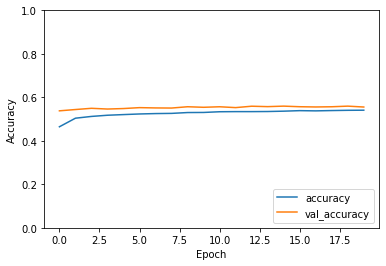

In [51]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [53]:
model = load_model('nn_wv_sg_1.h5')
y_preds = model.predict(X_test)
y_preds = np.argmax(y_preds, axis=1)
y_test_label_encoded = np.argmax(y_test_one_hot, axis=1)

accuracy = accuracy_score(y_test, y_preds)
f1_score_nn = f1_score(y_test_label_encoded, y_preds, average='weighted')
report = classification_report(y_test_label_encoded, y_preds)

print('NN Results:')
print(f'Accuracy: {accuracy}')
print(f'F1-score: {f1_score_nn}')
print(report)

1310/1310 [==============================] - 2s 1ms/step
NN Results:
Accuracy: 0.0
F1-score: 0.5102146939691555
              precision    recall  f1-score   support

           0       0.37      0.12      0.18       302
           1       0.44      0.07      0.12       268
           2       0.56      0.12      0.20       917
           3       0.49      0.36      0.42      1198
           4       0.46      0.11      0.18       229
           5       0.61      0.22      0.32      1080
           6       0.46      0.58      0.51       712
           7       0.47      0.23      0.31       215
           8       0.71      0.54      0.61       685
           9       0.43      0.23      0.30       203
          10       0.54      0.76      0.63      3473
          11       0.76      0.16      0.26       289
          12       0.56      0.02      0.03       280
          13       0.57      0.78      0.66      1268
          14       0.47      0.12      0.19       280
          15       0.41

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shrut\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shrut\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
